In [23]:
import torch
import sys
import yaml
from torchvision import transforms, datasets
import torchvision
import numpy as np
import os
from sklearn import preprocessing
from torch.utils.data.dataloader import DataLoader
import random
import importlib
importlib.reload(sys)

<module 'sys' (built-in)>

In [24]:
sys.path.append('../')
from models.pointnetv2_encoder import PointNetV2

In [25]:
batch_size = 10

In [26]:
config = yaml.load(open("../config/config.yaml", "r"), Loader=yaml.FullLoader)

In [27]:
seed = 741
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [28]:
# from data_utils.ModelNetDataLoader import ModelNetDataLoader
# train_dataset = ModelNetDataLoader('/data/nerdxie/neuron_cluster/neuron_dataset_1',split='train', uniform=True, normal_channel=True,istrain=False,)
# test_dataset = ModelNetDataLoader('/data/nerdxie/neuron_cluster/neuron_dataset_1',split='test', uniform=True, normal_channel=True,istrain=False,)
from data_utils.TestDataLoader import FAFBDataset
full_dataset = FAFBDataset('/data/chih0321/FAFB_Subcompartment_correct', uniform=True, normal_channel=True, catfile='classname_plus.txt')

labelname = ['neurite', 'glia', 'soma', 'axon_terminal']

train_size = int(0 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

The size of all data is 1723


In [29]:
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                          num_workers=4, drop_last=False, shuffle=True)

In [30]:
device = 'cuda' #'cuda' if torch.cuda.is_available() else 'cpu'
encoder = PointNetV2(**config['network']).to(device)
# encoder.projetion = torch.nn.Sequential()
# encoder = torch.nn.DataParallel(encoder).cuda()
encoder = encoder.cuda()

In [31]:
#load pre-trained parameters
load_params = torch.load(os.path.join('../pre-trained/model_sslcontrast.pth'),
                         map_location=torch.device(torch.device(device)))

# for i in load_params['online_network_state_dict'].keys():
#     if 'projetion' in i:
#         del load_params['online_network_state_dict'][i]
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in load_params['online_network_state_dict'].items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
if 'online_network_state_dict' in load_params:
    encoder.load_state_dict(new_state_dict)
    print("Parameters successfully loaded.")

# remove the projection head
# encoder = torch.nn.Sequential(*list(encoder.cpu().children())[:-1])    
# encoder = encoder.to(device)
# output_feature_dim = 1024

Parameters successfully loaded.


In [33]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.linear(x)

In [34]:
def get_features_from_encoder(encoder, loader):
    
    x_train = []
    y_train = []
    names = []

    # get the features from the pre-trained model
    for batch, y, index in loader:
        index = [int(i) for i in index]
        with torch.no_grad():
            batch = batch.to(device)
            features = encoder(batch)[1]
            x_train.extend(features)
            y_train.extend(y.numpy())
            names.extend(index)

            
    x_train = torch.stack(x_train)
    y_train = torch.tensor(y_train)
    names = torch.tensor(names)
    return x_train, y_train, names

In [35]:
encoder.eval()
x_test, y_test, name_test = get_features_from_encoder(encoder, test_loader)

if len(x_test.shape) > 2:
    x_test = torch.mean(x_test, dim=[2, 3])
    
print("Testing data shape:", x_test.shape, y_test.shape)

Testing data shape: torch.Size([1723, 1024]) torch.Size([1723, 1])


In [21]:
# def create_data_loaders_from_arrays(X_train, y_train, name_train, X_test, y_test, name_test, k_fold, k):
#     data_len = X_train.shape[0]
     
#     train = torch.utils.data.TensorDataset(torch.cat((X_train[:int((k % k_fold) * data_len / k_fold)],
#                                                      X_train[:int((k % k_fold + 1) * data_len / k_fold)]), 0), 
#                                            torch.cat((y_train[:int((k % k_fold) * data_len / k_fold)],
#                                                      y_train[:int((k % k_fold + 1) * data_len / k_fold)]), 0),
#                                            torch.cat((name_train[:int((k % k_fold) * data_len / k_fold)],
#                                                      name_train[:int((k % k_fold + 1) * data_len / k_fold)]), 0),)
#     train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
    
#     val = torch.utils.data.TensorDataset(X_train[int((k % k_fold) * data_len / k_fold):int((k % k_fold + 1) * data_len / k_fold)], 
#                                          y_train[int((k % k_fold) * data_len / k_fold):int((k % k_fold + 1) * data_len / k_fold)],
#                                          name_train[int((k % k_fold) * data_len / k_fold):int((k % k_fold + 1) * data_len / k_fold)])
#     val_loader = torch.utils.data.DataLoader(val, batch_size=64, shuffle=True)
    
    

#     test = torch.utils.data.TensorDataset(X_test, y_test, name_test)
#     test_loader = torch.utils.data.DataLoader(test, batch_size=512, shuffle=False)
#     return train_loader, val_loader, test_loader

In [22]:
# scaler = preprocessing.StandardScaler()
# scaler.fit(x_train.cpu())
# x_train = scaler.transform(x_train.cpu()).astype(np.float32)
# x_test = scaler.transform(x_test.cpu()).astype(np.float32)

logreg = LogisticRegression(1024, 3)
logreg = logreg.to(device)


# optimizer = torch.optim.Adam(logreg.parameters(), lr=3e-4)
optimizer = torch.optim.Adam([{'params': encoder.parameters(), 'lr': 1e-5},
                             {'params': logreg.parameters(), 'lr': 3e-4}],)
criterion = torch.nn.CrossEntropyLoss()

soma_acc = 0
neurite_acc = 0
glia_acc = 0
eval_every_n_epochs = 10
best_val = 0
test_acc = 0
best_epoch = 0
best_acc = 0

true_name = []

# train_loader, val_loader, test_loader = create_data_loaders_from_arrays(torch.from_numpy(x_train), y_train, name_train, torch.from_numpy(x_test), y_test, name_test, 1, 1)

for epoch in range(100):
#     train_acc = []
    for x, y, _ in train_loader:
        x = x.to(device)
        y = y.to(device).squeeze(1).long()
        
        x = encoder(x)[1]
        
        # zero the parameter gradients
        optimizer.zero_grad()        
        
        logits = logreg(x)
        predictions = torch.argmax(logits, dim=1)
        
        loss = criterion(logits, y)
        
        loss.backward()
        optimizer.step()
    
    total = 0
    ## test on val
    if epoch % eval_every_n_epochs == 0:
        if True:
            true_name = []
            best_val = val_acc
            correct_soma = 0
            correct_neurite = 0
            correct_glia = 0
            total_soma = 0
            total_neurite = 0
            total_glia = 0
            correct = 0
            total = 0
            for x, y, name in test_loader:
                x = x.to(device)
                y = y.to(device).squeeze(1).long()
                x = encoder(x)[1]

                logits = logreg(x)
                predictions = torch.argmax(logits, dim=1)

                total += y.size(0)
                total_neurite += (y == 0).sum().item()
                total_glia += (y == 1).sum().item()
                total_soma += (y == 2).sum().item()
                y = y.cpu().numpy()
                predictions = predictions.cpu().numpy()
                true_sample = y[np.where(predictions == y)]
                correct_neurite += (true_sample == 0).sum()
                correct_glia += (true_sample == 1).sum()      
                correct_soma += (true_sample == 2).sum()
                correct += len(true_sample)
                

            test_acc = np.mean(100 * correct / total)
            best_acc = max(test_acc, best_acc)
            soma_acc = correct_soma / total_soma
            glia_acc = correct_glia / total_glia
            neurite_acc = correct_neurite / total_neurite
            best_epoch = epoch
            
        print(f"Current Val Accuracy: {val_acc}, Current Test Accuracy: {test_acc} on Epoch {best_epoch}. Soma {soma_acc} Neurite {neurite_acc} Glia {glia_acc}")

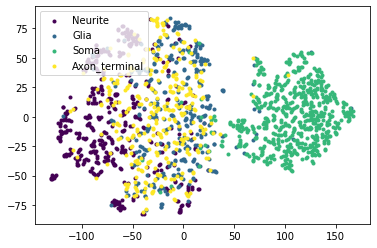

In [36]:
# import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
seed = 200
np.random.seed(seed)

cluster_num = 4
X = pd.DataFrame(x_test.cpu().numpy())
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=cluster_num,random_state=0)
# kmeans.fit(X)
# print(y_train.numpy())
# labels = kmeans.labels_
labels = pd.DataFrame(y_test.cpu().numpy())

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=4, perplexity=10, n_iter=5000)
a = tsne.fit_transform(X)
X.insert(0,'labels',labels)
liris = pd.DataFrame(a,index=X.index)
# liris.insert(2,'key',key)
liris.insert(2,'labels',labels)

color = plt.cm.viridis(np.linspace(0,1,cluster_num))
marker = markers=["D","x","h",".","^",">","v","*","o","s","3"]
labelname = ['Neurite', 'Glia', 'Soma', 'Axon_terminal']

for i in range(cluster_num):
    di = liris[X['labels']==i]
    plt.scatter(di[0],di[1],color=color[i],marker='.',label=labelname[i])
# plt.plot(d1[0],d1[1],'r.',d2[0],d2[1],'go',d3[0],d3[1],'b*', d4[0],d4[1],'y*', d5[0],d5[1],'kh', d6[0],d6[1],'ch', d7[0],d7[1],'mh', d8[0],d8[1],'wh', d9[0],d9[1],'gh', d10[0],d10[1],'ch')
plt.legend(loc = 2)#图例
plt.savefig('./unsupervised2.png', format='pdf',dpi=300, bbox_inches='tight')

In [21]:
X

,labels,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,4.264410e-09,0.046781,0.313170,0.0,0.099055,0.000000,0.318531,0.000000,0.0,...,0.818607,0.0,0.708162,0.323441,3.963676e-37,6.918211e-42,0.000000,0.0,0.216812,1.083017
1,2,4.263325e-09,0.214545,0.255211,0.0,0.057944,0.381333,0.234954,0.000000,0.0,...,0.848633,0.0,0.340857,0.288131,3.963676e-37,6.918211e-42,0.071079,0.0,0.570396,1.272223
2,2,4.264049e-09,0.193094,0.267639,0.0,0.071507,0.176672,0.277106,0.000000,0.0,...,0.452064,0.0,0.386853,0.256538,3.963676e-37,6.918211e-42,0.094661,0.0,0.577174,0.776425
3,1,4.263934e-09,0.210158,0.237711,0.0,0.054476,0.402800,0.419390,0.000000,0.0,...,0.598426,0.0,0.247796,0.231923,3.963676e-37,6.918211e-42,0.085918,0.0,0.450969,0.476653
4,0,4.265105e-09,0.010932,0.318771,0.0,0.043510,0.624597,0.119627,0.000082,0.0,...,0.695248,0.0,0.745677,0.115905,3.963676e-37,6.918211e-42,0.141250,0.0,0.640455,0.428635
5,2,4.263862e-09,0.146218,0.258993,0.0,0.061487,0.397392,0.242750,0.000000,0.0,...,0.559869,0.0,0.379299,0.252122,3.963676e-37,6.918211e-42,0.075368,0.0,0.591409,0.594369
6,0,4.266464e-09,0.040504,0.365542,0.0,0.078819,0.555825,0.094518,0.000376,0.0,...,0.880578,0.0,0.430040,0.063089,3.963676e-37,6.918211e-42,0.139949,0.0,0.192765,0.772307
7,2,4.263394e-09,0.151876,0.265750,0.0,0.065875,0.161685,0.327669,0.000000,0.0,...,0.515195,0.0,0.350702,0.266006,3.963676e-37,6.918211e-42,0.069921,0.0,0.543437,0.642181
8,2,4.263546e-09,0.165244,0.251176,0.0,0.070333,0.342174,0.265812,0.000000,0.0,...,0.432701,0.0,0.425339,0.246538,3.963676e-37,6.918211e-42,0.076548,0.0,0.503919,0.504500
9,0,4.263795e-09,0.206323,0.140546,0.0,0.060609,0.193898,0.153856,0.000000,0.0,...,0.365921,0.0,0.595726,0.178310,3.963676e-37,6.918211e-42,0.070465,0.0,0.361703,0.255944


In [11]:
names = pd.DataFrame(columns=['key'],data=list(name_test))

NameError: name 'pd' is not defined

In [22]:
data= pd.concat([liris,names],axis=1)
data.to_csv('post_keys.csv',encoding='gbk')